# Diagnostic Demand Visualisation by LSOA (MRI)

This notebook visualises the estimated **MRI** demand per LSOA across the South West region.  
We will:

1. Load spatial MRI demand outputs from `estimate_mri_demand_from_gpkg()`
2. Visualise demand as a choropleth map
3. Prepare a base for overlaying LSOA-to-LSOA travel data for network or gravity-style modelling


In [1]:
# ------------------------------------------------------------------
# Step 0 – Imports, File Paths, and Script Path Setup
# ------------------------------------------------------------------
import os
import sys
import pandas as pd
import geopandas as gpd
import fiona
import matplotlib.pyplot as plt

# Add the 'scripts' folder to the Python import path
script_dir = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/scripts"
if script_dir not in sys.path:
    sys.path.append(script_dir)

# File locations
data_dir = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/raw"

gpkg_path = os.path.join(data_dir, "LSOA_5-year_segment_master.gpkg")
travel_csv_path = os.path.join(data_dir, "LSOA_to_LSOA.csv")
modality_counts_path = os.path.join(data_dir, "modality_procedure_counts_by_age_band_2024.csv")
cdc_path = os.path.join(data_dir, "health_infra/NHS_SW_ Community_Diagnostic_Centres_enriched.csv")
acute_path = os.path.join(data_dir, "health_infra/NHS_SW_Acute_Hospitals_enriched.csv")

# Confirm file existence
for path in [gpkg_path, travel_csv_path, modality_counts_path, cdc_path, acute_path]:
    assert os.path.exists(path), f"Missing file: {path}"

# Utility function to preview column names
def print_columns(filepath, is_geopkg=False):
    print(f"\nColumns in: {os.path.basename(filepath)}")
    try:
        if is_geopkg:
            df = gpd.read_file(filepath)
        else:
            df = pd.read_csv(filepath, nrows=5)
        print(df.columns.tolist())
    except Exception as e:
        print(f"Could not read: {e}")

# Run checks
print_columns(gpkg_path, is_geopkg=True)
print_columns(travel_csv_path)
print_columns(modality_counts_path)
print_columns(cdc_path)
print_columns(acute_path)



Columns in: LSOA_5-year_segment_master.gpkg
['ICB23NM', 'ladnm', 'ladcd', 'msoa21nm', 'msoa21cd', 'lsoa21nmw', 'lsoa21cd', 'total_population', 'age_0_4', 'age_5_9', 'age_10_14', 'age_15_19', 'age_20_24', 'age_25_29', 'age_30_34', 'age_35_39', 'age_40_44', 'age_45_49', 'age_50_54', 'age_55_59', 'age_60_64', 'age_65_69', 'age_70_74', 'age_75_79', 'age_80_84', 'age_85_plus', 'lat', 'long', 'bng_e', 'bng_n', 'lsoa21nm', 'geometry']

Columns in: LSOA_to_LSOA.csv
['E01022150', 'E01014950', '42.7481676448875', '56.2881676448875', '56.2881676448875.1']

Columns in: modality_procedure_counts_by_age_band_2024.csv
['age_band', 'CT_Cancer Pathway', 'CT_Non-Cancer Pathway', 'CT_Total', 'Endoscopy_Cancer Pathway', 'Endoscopy_Non-Cancer Pathway', 'Endoscopy_Total', 'MRI_Cancer Pathway', 'MRI_Non-Cancer Pathway', 'MRI_Total']

Columns in: NHS_SW_ Community_Diagnostic_Centres_enriched.csv
['Code', 'Name', 'Address 1', 'Address 2', 'Address 3', 'Address 4', 'Address 5', 'Postcode', 'Type', 'Parent Orga

In [2]:
# ------------------------------------------------------------------
# Step 1 – Load MRI Demand Estimates
# ------------------------------------------------------------------
from estimate_mri_demand_from_gpkg import estimate_mri_demand_from_gpkg

mri_demand_df = estimate_mri_demand_from_gpkg()
print("Loaded MRI demand per LSOA:")
display(mri_demand_df.head())


Loaded MRI demand per LSOA:


,lsoa21cd,mri_total_demand,mri_age_0_4,mri_age_5_9,mri_age_10_14,mri_age_15_19,mri_age_20_24,mri_age_25_29,mri_age_30_34,mri_age_35_39,mri_age_40_44,mri_age_45_49,mri_age_50_54,mri_age_55_59,mri_age_60_64,mri_age_65_69,mri_age_70_74,mri_age_75_79,mri_age_80_84,mri_age_85_plus
0,E01020484,86.103249,0.420034,0.674371,1.473437,2.436694,1.792333,1.740134,3.326240,4.254983,3.977259,5.002384,7.013377,8.454571,10.699525,9.221666,8.839622,8.570267,5.471246,2.735108
1,E01020481,89.386028,0.380968,0.312741,0.796399,0.878502,1.503412,1.817659,2.507116,2.587459,3.219774,3.394224,4.457436,8.756494,13.633457,11.616180,12.549362,11.282391,5.295202,4.397253
2,E01020482,94.250505,0.673916,0.742855,1.453478,1.331814,1.907958,2.939113,4.917585,4.657878,5.555507,5.240564,5.964720,9.587337,12.770236,9.044779,10.260539,10.089440,4.323923,2.788862
3,E01020479,75.457109,0.322320,0.312741,0.637120,1.303413,0.953979,1.392031,1.735368,1.609887,1.830743,2.977554,3.277375,5.737269,6.644593,9.221666,8.287388,12.801564,8.207302,8.204797
4,E01020478,69.763845,0.361387,0.430018,1.015556,1.643397,1.358809,1.237361,1.928186,2.817443,3.535548,3.275426,5.309631,7.775060,7.852084,7.803082,7.340369,8.895424,4.235468,2.949595


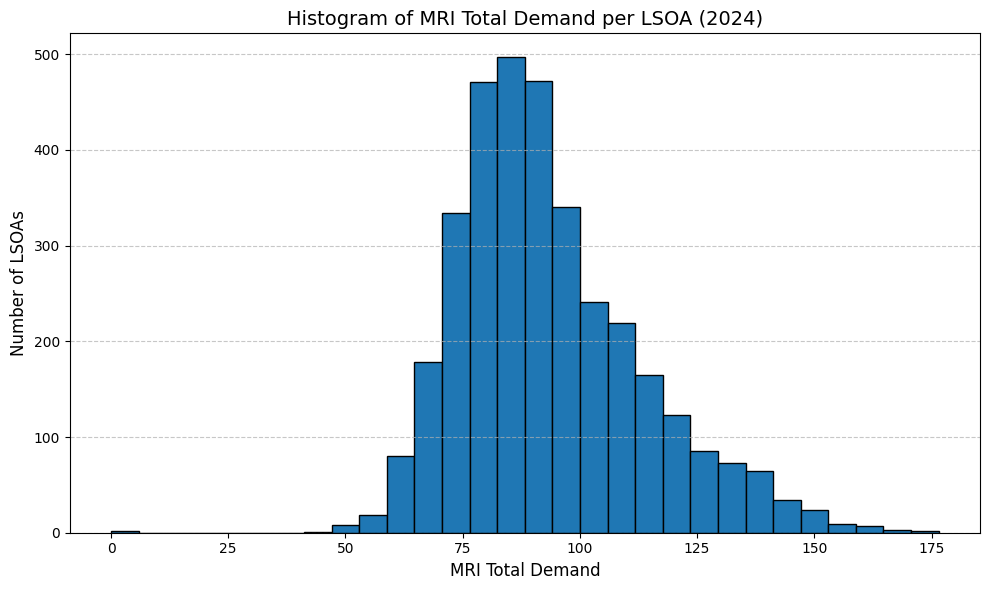

In [3]:
# ------------------------------------------------------------------
# Step 1a – Histogram of MRI Total Demand per LSOA
# ------------------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.hist(mri_demand_df["mri_total_demand"], bins=30, edgecolor='black')

plt.title("Histogram of MRI Total Demand per LSOA (2024)", fontsize=14)
plt.xlabel("MRI Total Demand", fontsize=12)
plt.ylabel("Number of LSOAs", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [4]:
# ------------------------------------------------------------------
# Step 1b – Check for LSOAs with Zero or Very Low MRI Demand
# ------------------------------------------------------------------
zero_demand = mri_demand_df[mri_demand_df["mri_total_demand"] == 0]
print(f"LSOAs with zero MRI demand: {len(zero_demand)}")
print(zero_demand)

# Optional: Check for LSOAs with very low demand (e.g., less than 5)
low_demand = mri_demand_df[mri_demand_df["mri_total_demand"] < 5]
print(f"\nLSOAs with very low MRI demand (< 5): {len(low_demand)}")
print(low_demand)


LSOAs with zero MRI demand: 2
       lsoa21cd  mri_total_demand  mri_age_0_4  mri_age_5_9  mri_age_10_14  \
2010  W01001595               0.0          NaN          NaN            NaN   
2011  W01001599               0.0          NaN          NaN            NaN   

      mri_age_15_19  mri_age_20_24  mri_age_25_29  mri_age_30_34  \
2010            NaN            NaN            NaN            NaN   
2011            NaN            NaN            NaN            NaN   

      mri_age_35_39  mri_age_40_44  mri_age_45_49  mri_age_50_54  \
2010            NaN            NaN            NaN            NaN   
2011            NaN            NaN            NaN            NaN   

      mri_age_55_59  mri_age_60_64  mri_age_65_69  mri_age_70_74  \
2010            NaN            NaN            NaN            NaN   
2011            NaN            NaN            NaN            NaN   

      mri_age_75_79  mri_age_80_84  mri_age_85_plus  
2010            NaN            NaN              NaN  
2011        

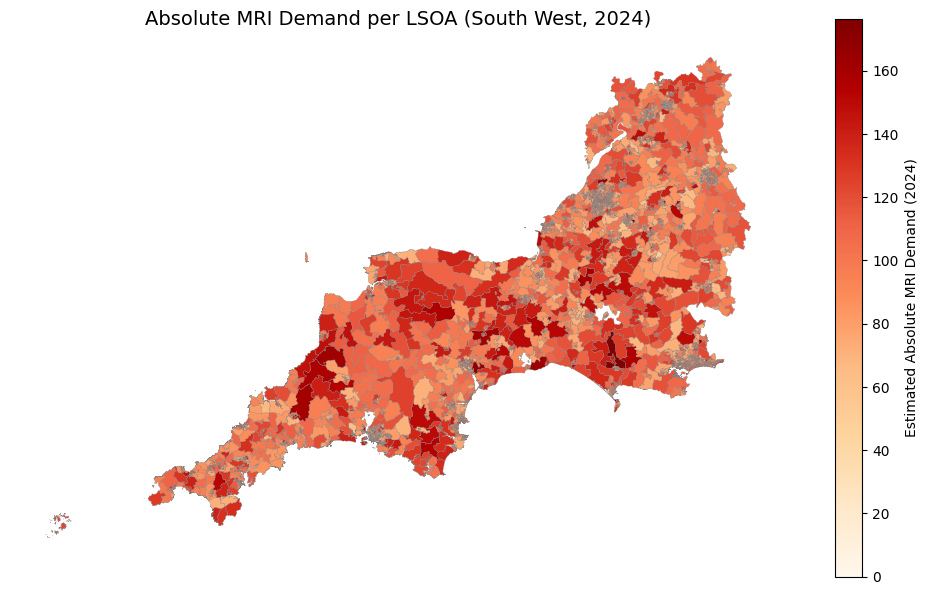

In [5]:
# ------------------------------------------------------------------
# Step 2 – Choropleth of Absolute MRI Demand per LSOA (2024, 300 DPI)
# ------------------------------------------------------------------

# Reload GPKG with geometry
gdf_geom = gpd.read_file(gpkg_path)[["lsoa21cd", "geometry"]]

# Merge with MRI demand
gdf_mri = gdf_geom.merge(
    mri_demand_df[["lsoa21cd", "mri_total_demand"]],
    on="lsoa21cd",
    how="left"
)

# Plot choropleth
fig, ax = plt.subplots(figsize=(10, 6))  # shorter height for cleaner layout
gdf_mri.plot(
    column="mri_total_demand",
    cmap="OrRd",
    linewidth=0.2,
    edgecolor="grey",
    legend=True,
    legend_kwds={'label': "Estimated Absolute MRI Demand (2024)"},
    ax=ax
)

ax.set_title("Absolute MRI Demand per LSOA (South West, 2024)", fontsize=14)
ax.axis("off")
plt.tight_layout()

# Save at high resolution (optional)
output_path = "mri_demand_absolute_choropleth_2024.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")
plt.show()


In [6]:
# ------------------------------------------------------------------
# Step 3 – Compute Nearest Diagnostic Site (CDC or Acute) by Car Travel Time (for MRI)
# ------------------------------------------------------------------

# Load LSOA-to-LSOA travel matrix (with unnamed columns)
travel_df = pd.read_csv(travel_csv_path, header=None)
travel_df.columns = [
    "origin_lsoa",
    "dest_lsoa",
    "car_travel_minutes",
    "placeholder_1",
    "placeholder_2"
]

# Ensure correct data types
travel_df["car_travel_minutes"] = pd.to_numeric(travel_df["car_travel_minutes"], errors="coerce")
travel_df["origin_lsoa"] = travel_df["origin_lsoa"].astype(str)
travel_df["dest_lsoa"] = travel_df["dest_lsoa"].astype(str)

# Load and tag Community Diagnostic Centres (CDC) and Acute sites
cdc_df = pd.read_csv(cdc_path)
acute_df = pd.read_csv(acute_path)

facilities_df = pd.concat([
    cdc_df[["Name", "lsoa21cd"]].assign(facility_type="CDC"),
    acute_df[["Name", "lsoa21cd"]].assign(facility_type="Acute")
], ignore_index=True).dropna(subset=["lsoa21cd"]).drop_duplicates()

facilities_df["lsoa21cd"] = facilities_df["lsoa21cd"].astype(str)

# Join travel matrix with facility locations
nearest_candidates = travel_df.merge(
    facilities_df,
    left_on="dest_lsoa",
    right_on="lsoa21cd",
    how="inner"
).drop(columns=["lsoa21cd"])  # remove duplicate column after merge

# Identify the nearest site by shortest travel time for each origin LSOA
nearest_sites = (
    nearest_candidates
    .sort_values("car_travel_minutes")
    .groupby("origin_lsoa")
    .first()
    .reset_index()
    .rename(columns={
        "origin_lsoa": "lsoa21cd",
        "Name": "nearest_site",
        "facility_type": "nearest_type",
        "car_travel_minutes": "travel_to_nearest_mins"
    })[[
        "lsoa21cd",
        "nearest_site",
        "nearest_type",
        "travel_to_nearest_mins"
    ]]
)

# Merge nearest site info with MRI demand GeoDataFrame
gdf_mri["lsoa21cd"] = gdf_mri["lsoa21cd"].astype(str)
nearest_sites["lsoa21cd"] = nearest_sites["lsoa21cd"].astype(str)

gdf_mri = gdf_mri.merge(nearest_sites, on="lsoa21cd", how="left")

# Tag if the LSOA contains a facility (i.e., 0 min travel time)
facility_lsoas = set(facilities_df["lsoa21cd"])
gdf_mri["facility_onsite"] = gdf_mri["lsoa21cd"].isin(facility_lsoas)

# Preview result
gdf_mri[[
    "lsoa21cd",
    "mri_total_demand",
    "nearest_site",
    "nearest_type",
    "travel_to_nearest_mins",
    "facility_onsite"
]].head()


,lsoa21cd,mri_total_demand,nearest_site,nearest_type,travel_to_nearest_mins,facility_onsite
0,E01020484,86.103249,Dorset Health Village Poole Beales CDC,CDC,37.262783,False
1,E01020481,89.386028,Dorset Health Village Poole Beales CDC,CDC,40.298602,False
2,E01020482,94.250505,Dorset Health Village Poole Beales CDC,CDC,37.925839,False
3,E01020479,75.457109,Dorset Health Village Poole Beales CDC,CDC,38.583952,False
4,E01020478,69.763845,Dorset Health Village Poole Beales CDC,CDC,36.993783,False


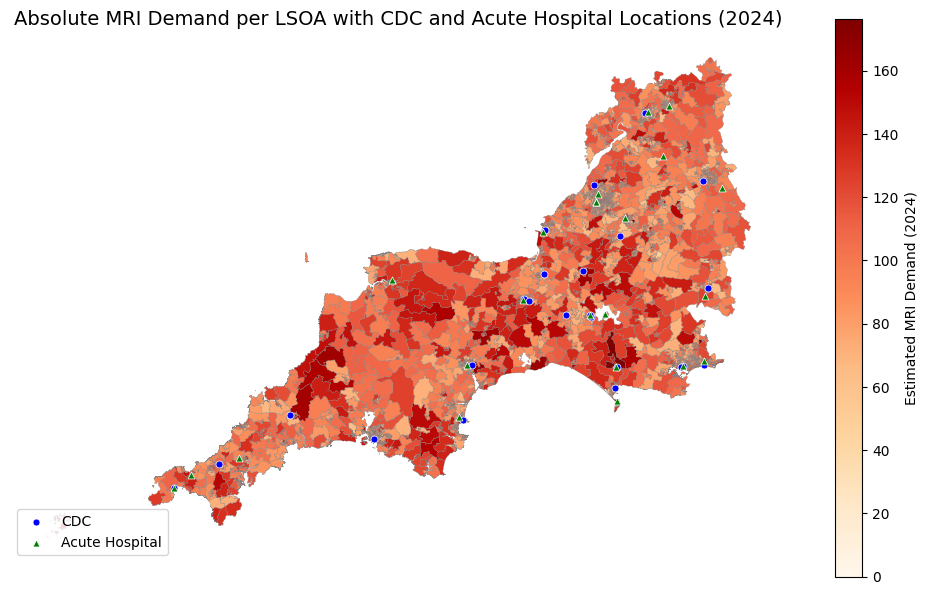

In [7]:
# ------------------------------------------------------------------
# Step 4 – Overlay MRI Demand Choropleth with Facility Locations
# ------------------------------------------------------------------

# 4.1 – Rebuild Base MRI Demand GeoDataFrame (if needed)
gdf_geom = gpd.read_file(gpkg_path)[["lsoa21cd", "geometry"]]
gdf_mri = gdf_geom.merge(
    mri_demand_df[["lsoa21cd", "mri_total_demand"]],
    on="lsoa21cd",
    how="left"
)

# 4.2 – Prepare Facility Point Locations
facilities_df = pd.concat([
    cdc_df.assign(site_type="CDC"),
    acute_df.assign(site_type="Acute")
], ignore_index=True).dropna(subset=["lsoa21cd"]).drop_duplicates()

facilities_df["lsoa21cd"] = facilities_df["lsoa21cd"].astype(str)

# Merge facility records with geometry
facilities_gdf = facilities_df.merge(gdf_geom, on="lsoa21cd", how="left")
facilities_gdf = gpd.GeoDataFrame(facilities_gdf, geometry="geometry", crs=gdf_geom.crs)

# Use centroids for plotting locations
facilities_gdf["centroid"] = facilities_gdf.geometry.centroid
facilities_gdf = facilities_gdf.set_geometry("centroid")

# Split by facility type
cdc_gdf = facilities_gdf[facilities_gdf["site_type"] == "CDC"]
acute_gdf = facilities_gdf[facilities_gdf["site_type"] == "Acute"]

# 4.3 – Plot MRI Demand with Facility Overlays
fig, ax = plt.subplots(figsize=(10, 6))

# Plot MRI demand choropleth
gdf_mri.plot(
    column="mri_total_demand",
    cmap="OrRd",
    linewidth=0.2,
    edgecolor="grey",
    legend=True,
    legend_kwds={'label': "Estimated MRI Demand (2024)"},
    ax=ax
)

# Overlay CDCs and Acute Hospitals
cdc_gdf.plot(
    ax=ax,
    color="blue",
    markersize=25,
    label="CDC",
    marker="o",
    edgecolor="white",
    linewidth=0.5
)

acute_gdf.plot(
    ax=ax,
    color="green",
    markersize=25,
    label="Acute Hospital",
    marker="^",
    edgecolor="white",
    linewidth=0.5
)

# Final formatting
ax.set_title("Absolute MRI Demand per LSOA with CDC and Acute Hospital Locations (2024)", fontsize=14)
ax.axis("off")
ax.legend(loc="lower left", frameon=True)

plt.tight_layout()
plt.savefig("mri_demand_with_facilities_overlay_2024.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
# ------------------------------------------------------------------
# Step 5 – Visualise MRI Catchment Areas by Nearest Facility
# ------------------------------------------------------------------

# 5.1 – Load Base Geometry and MRI Demand
gdf_geom = gpd.read_file(gpkg_path)[["lsoa21cd", "geometry"]]
gdf_mri = gdf_geom.merge(
    mri_demand_df[["lsoa21cd", "mri_total_demand"]],
    on="lsoa21cd",
    how="left"
)

# 5.2 – Merge Travel Info and Nearest Site Assignments
nearest_sites["lsoa21cd"] = nearest_sites["lsoa21cd"].astype(str)
gdf_mri["lsoa21cd"] = gdf_mri["lsoa21cd"].astype(str)

gdf_mri = gdf_mri.merge(
    nearest_sites[[
        "lsoa21cd",
        "nearest_site",
        "nearest_type",
        "travel_to_nearest_mins"
    ]],
    on="lsoa21cd",
    how="left"
)

# 5.3 – Prepare Facility Points
facilities_df = pd.concat([
    cdc_df.assign(site_type="CDC"),
    acute_df.assign(site_type="Acute")
], ignore_index=True).dropna(subset=["lsoa21cd"]).drop_duplicates()

facilities_df["lsoa21cd"] = facilities_df["lsoa21cd"].astype(str)

facilities_gdf = facilities_df.merge(gdf_geom, on="lsoa21cd", how="left")
facilities_gdf = gpd.GeoDataFrame(facilities_gdf, geometry="geometry", crs=gdf_geom.crs)

# Use LSOA centroids for plotting points
facilities_gdf["centroid"] = facilities_gdf.geometry.centroid
facilities_gdf = facilities_gdf.set_geometry("centroid")

# Split by facility type
cdc_gdf = facilities_gdf[facilities_gdf["site_type"] == "CDC"]
acute_gdf = facilities_gdf[facilities_gdf["site_type"] == "Acute"]

# 5.4 – Create Catchment Polygons by Nearest Facility
catchment_gdf = gdf_mri.dissolve(by="nearest_site", as_index=False)

# Map site type back to catchments
site_type_map = facilities_df.set_index("Name")["site_type"].to_dict()
catchment_gdf["site_type"] = catchment_gdf["nearest_site"].map(site_type_map)

# Split catchments by facility type
catchment_cdc = catchment_gdf[catchment_gdf["site_type"] == "CDC"]
catchment_acute = catchment_gdf[catchment_gdf["site_type"] == "Acute"]

# 5.5 – Plot MRI Demand with Catchments and Facilities
fig, ax = plt.subplots(figsize=(11, 7))

# Base: MRI demand choropleth
gdf_mri.plot(
    column="mri_total_demand",
    cmap="OrRd",
    linewidth=0.1,
    edgecolor="grey",
    legend=True,
    legend_kwds={'label': "Estimated MRI Demand (2024)"},
    ax=ax,
    alpha=0.9
)

# Catchment overlays
catchment_cdc.plot(
    ax=ax,
    facecolor="none",
    edgecolor="blue",
    linewidth=1.2,
    linestyle="-",
    label="CDC Catchment"
)

catchment_acute.plot(
    ax=ax,
    facecolor="none",
    edgecolor="green",
    linewidth=1.2,
    linestyle="--",
    label="Acute Catchment"
)

# Facility markers
cdc_gdf.plot(
    ax=ax,
    color="blue",
    markersize=40,
    marker="o",
    edgecolor="white",
    label="CDC"
)

acute_gdf.plot(
    ax=ax,
    color="green",
    markersize=40,
    marker="^",
    edgecolor="white",
    label="Acute Hospital"
)

# Final formatting
ax.set_title("Absolute MRI Demand with Catchment Areas by Nearest CDC or Acute Hospital (2024)", fontsize=14)
ax.axis("off")
ax.legend(loc="lower left", frameon=True)
plt.tight_layout()

# Save output
plt.savefig("mri_demand_with_catchments_and_sites_2024.png", dpi=300, bbox_inches="tight")
plt.show()
